# On/Off Poisson Counting Experiment

Simulation-based inference for the classic On/Off Poisson counting experiment using conditional flow matching to learn the posterior and the Waldo test statistic ([Masserano et al. 2205.15680](https://arxiv.org/abs/2205.15680)) for confidence intervals.


**Model:**
- POI: signal strength $\mu \in [0, 5]$
- Nuisance: background scaling $\nu \in [0.6, 1.4]$
- Data: $n_s \sim \mathrm{Poisson}(\nu b + \mu s)$, $n_b \sim \mathrm{Poisson}(\nu \tau b)$
- Fixed: $s = 15$, $b = 70$, $\tau = 1$

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import nami
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

##  On/Off simulator

In [6]:
# fixed hyperparameters
S, B, TAU = 15.0, 70.0, 1.0
MU_LO, MU_HI = 0.0, 5.0
NU_LO, NU_HI = 0.6, 1.4


def on_off_simulate(mu, nu):
    """Sample (n_signal, n_background) from the On/Off model.
        args: mu, nu : 
            Tensor, shape (batch,)

        returns: Tensor, shape (batch, 2)
    """
    rate_s = (nu * B + mu * S).clamp(min=1e-6)
    rate_b = (nu * TAU * B).clamp(min=1e-6)
    n_s = torch.poisson(rate_s)
    n_b = torch.poisson(rate_b)
    return torch.stack([n_s, n_b], dim=-1)


def sample_prior(n):
    """Draw (mu, nu) from the joint prior."""
    mu = torch.empty(n).uniform_(MU_LO, MU_HI)
    nu = torch.empty(n).uniform_(NU_LO, NU_HI)
    return mu, nu

## generate training data from the prior predictive

In [7]:
torch.manual_seed(42)

N_TRAIN = 200_000
mu_train, nu_train = sample_prior(N_TRAIN)
theta_train = torch.stack([mu_train, nu_train], dim=-1)  # (N, 2)
x_train = on_off_simulate(mu_train, nu_train)            # (N, 2)

# standardise the conditioning data (Poisson counts ~ 70-100)
x_mean = x_train.mean(0)
x_std  = x_train.std(0)
x_train_norm = (x_train - x_mean) / x_std

print(f"theta  : {theta_train.shape}  range mu=[{mu_train.min():.2f}, {mu_train.max():.2f}]  nu=[{nu_train.min():.2f}, {nu_train.max():.2f}]")
print(f"x      : {x_train.shape}  mean={x_mean.numpy().round(1)}  std={x_std.numpy().round(1)}")

theta  : torch.Size([200000, 2])  range mu=[0.00, 5.00]  nu=[0.60, 1.40]
x      : torch.Size([200000, 2])  mean=[107.5  69.9]  std=[29.  18.2]


## Conditional velocity field

An MLP that maps $(\theta_t, t, x)$ to a velocity in parameter space.
`event_ndim = 1` because a single "event" is the 2D parameter vector $(\mu, \nu)$.

In [8]:
class PosteriorField(nn.Module):
    def __init__(self, param_dim=2, cond_dim=2, hidden=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(param_dim + 1 + cond_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, param_dim),
        )

    @property
    def event_ndim(self):
        return 1

    def forward(self, x, t, c=None):
        t_exp = t.unsqueeze(-1).expand(*x.shape[:-1], 1)
        parts = [x, t_exp]
        if c is not None:
            parts.append(c)
        return self.net(torch.cat(parts, dim=-1))


field = PosteriorField()
print(f"Parameters: {sum(p.numel() for p in field.parameters()):,}")

Parameters: 529,410


## Train

Each mini-batch: draw $(\theta, x)$ pairs from the training set, sample noise $\theta_{\text{source}} \sim \mathcal{N}(0, I)$, and minimise the conditional flow matching loss with $x$ as conditioning.

Step     1/10000  loss = 5.7071
Step  1000/10000  loss = 0.5698
Step  2000/10000  loss = 0.5746
Step  3000/10000  loss = 0.5926
Step  4000/10000  loss = 0.6142
Step  5000/10000  loss = 0.6316
Step  6000/10000  loss = 0.5882
Step  7000/10000  loss = 0.5898
Step  8000/10000  loss = 0.5877
Step  9000/10000  loss = 0.6210
Step 10000/10000  loss = 0.5946


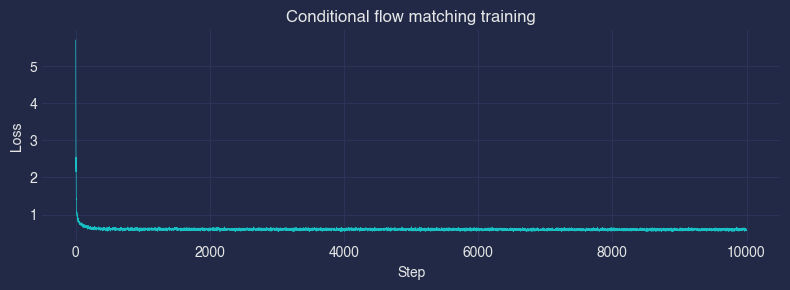

In [9]:
optimizer = torch.optim.Adam(field.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8000)

batch_size = 2048
n_steps = 10000
losses = []

for step in range(1, n_steps + 1):
    idx = torch.randint(0, N_TRAIN, (batch_size,))
    theta_target = theta_train[idx]
    theta_source = torch.randn_like(theta_target)
    x_cond = x_train_norm[idx]

    loss = nami.fm_loss(field, theta_target, theta_source, c=x_cond)
    #loss = stochastic_fm_loss(field, theta_target, theta_source, c=x_cond)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    losses.append(loss.item())
    if step % 1000 == 0 or step == 1:
        print(f"Step {step:>5}/{n_steps}  loss = {loss.item():.4f}")

plt.figure(figsize=(8, 3))
plt.plot(losses, linewidth=0.5)
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("Conditional flow matching training")
plt.tight_layout()
plt.show()

## Posterior sampling

Pick a "true" parameter point, draw one observed dataset $x_{\text{obs}}$, then sample from the learned posterior $p(\theta \mid x_{\text{obs}})$ by integrating the conditional ODE.

In [10]:
# ground truth + observation
mu_true, nu_true = 2.0, 1.0

torch.manual_seed(7)
x_obs = on_off_simulate(
    torch.tensor([mu_true]), torch.tensor([nu_true])
)  # (1, 2)
x_obs_norm = (x_obs - x_mean) / x_std  # standardise

print(f"True parameters : mu={mu_true}, nu={nu_true}")
print(f"Observed counts : n_s={x_obs[0, 0]:.0f}, n_b={x_obs[0, 1]:.0f}")

True parameters : mu=2.0, nu=1.0
Observed counts : n_s=93, n_b=81


In [11]:
# draw posterior samples
n_posterior = 5_000

# repeat x_obs so each posterior draw gets the same conditioning
x_obs_rep = x_obs_norm.expand(n_posterior, -1)  # (n_posterior, 2)

fm = nami.FlowMatching(
    field,
    nami.StandardNormal(event_shape=(2,)),
    nami.RK4(steps=100),
    event_ndim=1,
)
process = fm(x_obs_rep)  # bind conditioning

with torch.no_grad():
    posterior_samples = process.sample((1,)).squeeze(0)  # (n_posterior, 2)

mu_post = posterior_samples[:, 0].numpy()
nu_post = posterior_samples[:, 1].numpy()

print(f"Posterior mean  : mu={mu_post.mean():.3f}, nu={nu_post.mean():.3f}")
print(f"Posterior std   : mu={mu_post.std():.3f}, nu={nu_post.std():.3f}")

Posterior mean  : mu=1.099, nu=1.137
Posterior std   : mu=0.675, nu=0.104


## Posterior visualisation

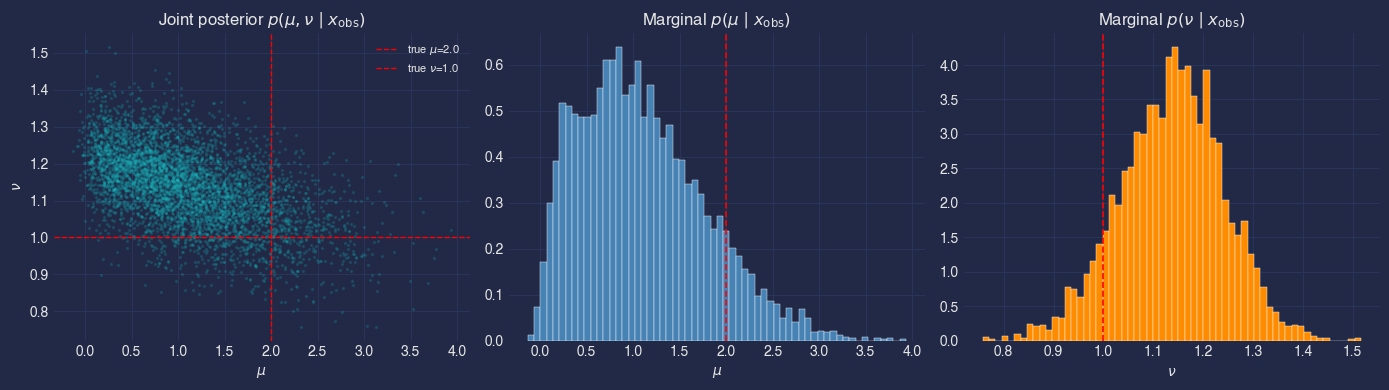

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# joint posterior
ax = axes[0]
ax.scatter(mu_post, nu_post, s=2, alpha=0.15, rasterized=True)
ax.axvline(mu_true, color="red", ls="--", lw=1, label=f"true $\\mu$={mu_true}")
ax.axhline(nu_true, color="red", ls="--", lw=1, label=f"true $\\nu$={nu_true}")
ax.set_xlabel(r"$\mu$"); ax.set_ylabel(r"$\nu$")
ax.set_title(r"Joint posterior $p(\mu, \nu \mid x_{\mathrm{obs}})$")
ax.legend(fontsize=8)

# marginal mu
ax = axes[1]
ax.hist(mu_post, bins=60, density=True, color="steelblue", edgecolor="white", lw=0.3)
ax.axvline(mu_true, color="red", ls="--", lw=1.2)
ax.set_xlabel(r"$\mu$")
ax.set_title(r"Marginal $p(\mu \mid x_{\mathrm{obs}})$")

# marginal nu
ax = axes[2]
ax.hist(nu_post, bins=60, density=True, color="darkorange", edgecolor="white", lw=0.3)
ax.axvline(nu_true, color="red", ls="--", lw=1.2)
ax.set_xlabel(r"$\nu$")
ax.set_title(r"Marginal $p(\nu \mid x_{\mathrm{obs}})$")

plt.tight_layout()
plt.show()

## Waldo test statistic

For the parameter of interest $\mu$ (profiling over nuisance $\nu$), the marginal Waldo statistic at hypothesis $\mu_0$ is
$$
W(\mu_0) = \frac{\big(\hat{\mu} - \mu_0\big)^2}{\widehat{\mathrm{Var}}[\mu \mid x]}
$$

where $\hat{\mu}$ and $\widehat{\mathrm{Var}}$ are estimated from the posterior samples. Under regularity conditions $W \xrightarrow{d} \chi^2_1$, so the $1 - \alpha$ confidence set is $\{\mu_0 : W(\mu_0) < \chi^2_{1, 1-\alpha}\}$.

*(This is the 1D-POI variant of the statistic in
[Masserano et al.](https://arxiv.org/abs/2205.15680).)*

In [13]:
# conditional mean and variance from posterior samples
mu_hat = mu_post.mean()
mu_var = mu_post.var()

# evaluate Waldo over a grid of hypothesised mu values
mu_grid = np.linspace(MU_LO, MU_HI, 300)
waldo = (mu_hat - mu_grid) ** 2 / mu_var

# chi^2(1) critical values
chi2_90 = 2.706
chi2_95 = 3.841

ci90 = mu_grid[waldo < chi2_90]
ci95 = mu_grid[waldo < chi2_95]

print(f"Posterior mean   E[mu|x] = {mu_hat:.3f}")
print(f"Posterior var  Var[mu|x] = {mu_var:.3f}")
print(f"90% CI: [{ci90.min():.2f}, {ci90.max():.2f}]")
print(f"95% CI: [{ci95.min():.2f}, {ci95.max():.2f}]")

Posterior mean   E[mu|x] = 1.099
Posterior var  Var[mu|x] = 0.455
90% CI: [0.00, 2.21]
95% CI: [0.00, 2.41]


## Diagnostics:

Is the posterior well-calibrated?

is the posterior mean for $\mu$ is notably biased low? flow converged and big enough

Red flags that indicate a bad model

Loss plateau too high or unstable,

Posterior mean far from the truth, even outside the CI,

Posterior too narrow or too wide,

Posterior samples outside the prior support,

Asymmetric or multi-modal artefacts in the marginals,

## Coverage test

calibration diagnostic: repeat inference for many independent observations and check that the nominal 95% CI contains the true $\mu$ approximately 95% of the time.

**Protocol** (inspired by [Masserano et al.](https://arxiv.org/abs/2205.15680)
/ lf2i):
- Draw $N_{\text{test}}$ parameter pairs $(\mu_i, \nu_i)$ from the prior.
- Simulate one observation $x_i$ per pair.
- For each $x_i$, draw $N_{\text{post}}$ posterior samples $\theta^{(j)} \sim p(\theta \mid x_i)$.
- Compute the marginal Waldo statistic
   $W_i = (\hat\mu_i - \mu_i)^2 / \widehat{\mathrm{Var}}[\mu \mid x_i]$.
- An observation is "covered" if $W_i < \chi^2_{1, 1-\alpha}$.
- Report the empirical coverage fraction, it should be close to $1-\alpha$.

batch all $N_{\text{test}} \times N_{\text{post}}$ posterior draws through a single ODE solve for efficiency.

In [14]:
torch.manual_seed(123)

N_TEST = 500       # independent observations
N_POST = 1000      # posterior samples per observation
ODE_STEPS = 50     # solver steps (fewer for speed)

# sample parameters and simulate data
mu_test, nu_test = sample_prior(N_TEST)
theta_test = torch.stack([mu_test, nu_test], dim=-1)
x_test = on_off_simulate(mu_test, nu_test)
x_test_norm = (x_test - x_mean) / x_std

#  draw posterior samples for ALL observations in one batched ODE solve
#    Conditioning shape: (N_TEST, 2)
#    Output shape: (N_POST, N_TEST, 2)
fm_cov = nami.FlowMatching(
    field, nami.StandardNormal(event_shape=(2,)),
    nami.RK4(steps=ODE_STEPS), event_ndim=1,
)
process_cov = fm_cov(x_test_norm)

with torch.no_grad():
    post_samples = process_cov.sample((N_POST,))  # (N_POST, N_TEST, 2)

# marrginal Waldo for the POI mu
mu_post_mean = post_samples[:, :, 0].mean(dim=0).numpy()   # (N_TEST,)
mu_post_var  = post_samples[:, :, 0].var(dim=0).numpy()    # (N_TEST,)
mu_true_arr  = mu_test.numpy()

waldo_cov = (mu_post_mean - mu_true_arr) ** 2 / np.clip(mu_post_var, 1e-8, None)

# empirical coverage at several levels
chi2_levels = {"90%": 2.706, "95%": 3.841, "99%": 6.635}

print(f"Coverage test  |  N_test = {N_TEST},  N_post = {N_POST},  ODE steps = {ODE_STEPS}")
print("-" * 55)
for label, cutoff in chi2_levels.items():
    cov = (waldo_cov < cutoff).mean()
    print(f"  Nominal {label}  →  Empirical {cov:.1%}")

Coverage test  |  N_test = 500,  N_post = 1000,  ODE steps = 50
-------------------------------------------------------
  Nominal 90%  →  Empirical 91.0%
  Nominal 95%  →  Empirical 95.6%
  Nominal 99%  →  Empirical 97.8%


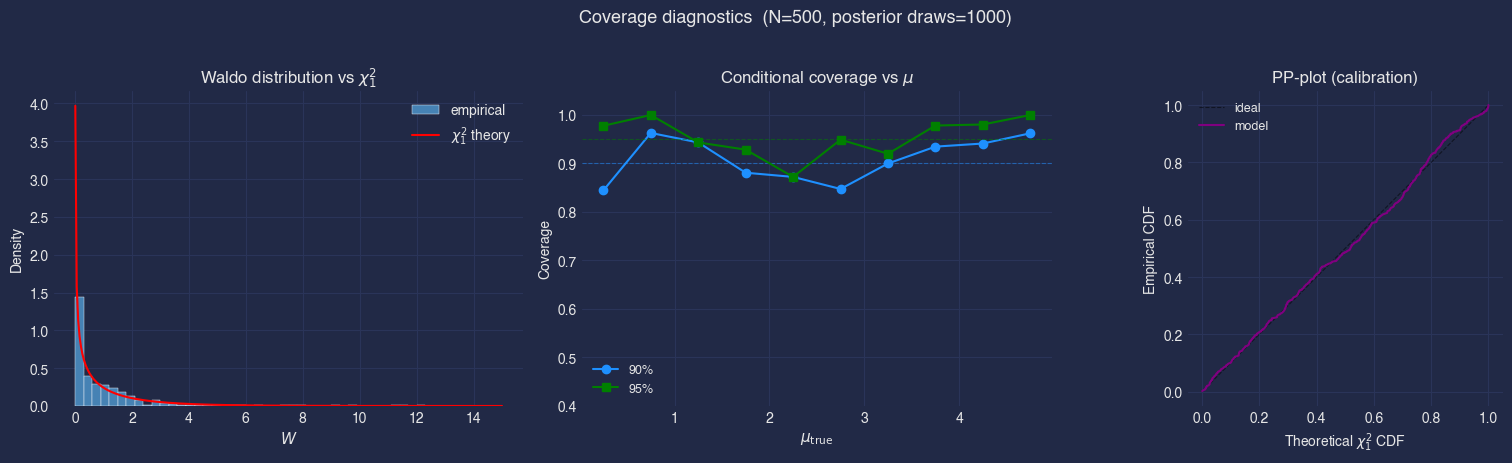

In [15]:
from scipy.stats import chi2 as chi2_dist
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# Waldo distribution vs chi2
ax = axes[0]
ax.hist(waldo_cov, bins=50, density=True, range=(0, 15),
        color="steelblue", edgecolor="white", lw=0.3, label="empirical")
x_th = np.linspace(0.01, 15, 300)
ax.plot(x_th, chi2_dist.pdf(x_th, df=1), "r-", lw=1.5, label=r"$\chi^2_1$ theory")
ax.set_xlabel("$W$", fontsize=11)
ax.set_ylabel("Density")
ax.set_title(r"Waldo distribution vs $\chi^2_1$")
ax.legend()

# conditional coverage as a function of mu
ax = axes[1]
n_bins = 10
mu_bins = np.linspace(MU_LO, MU_HI, n_bins + 1)
bin_idx = np.digitize(mu_true_arr, mu_bins) - 1
bin_centers = 0.5 * (mu_bins[:-1] + mu_bins[1:])

for label, cutoff, color, marker in [
    ("90%", 2.706, "dodgerblue", "o"),
    ("95%", 3.841, "green", "s"),
]:
    cov_per_bin = np.array([
        (waldo_cov[bin_idx == i] < cutoff).mean()
        if (bin_idx == i).sum() > 0 else np.nan
        for i in range(n_bins)
    ])
    ax.plot(bin_centers, cov_per_bin, f"{marker}-", color=color, label=label)
    ax.axhline(float(label.strip("%")) / 100, color=color, ls="--", lw=0.8, alpha=0.5)

ax.set_xlabel(r"$\mu_{\mathrm{true}}$", fontsize=11)
ax.set_ylabel("Coverage")
ax.set_ylim(0.4, 1.05)
ax.set_title(r"Conditional coverage vs $\mu$")
ax.legend(fontsize=9)

# PP-plot
ax = axes[2]
sorted_w = np.sort(waldo_cov)
empirical_cdf = np.arange(1, len(sorted_w) + 1) / len(sorted_w)
theoretical_cdf = chi2_dist.cdf(sorted_w, df=1)

ax.plot([0, 1], [0, 1], "k--", lw=0.8, alpha=0.5, label="ideal")
ax.plot(theoretical_cdf, empirical_cdf, color="purple", lw=1.5, label="model")
ax.set_xlabel(r"Theoretical $\chi^2_1$ CDF")
ax.set_ylabel("Empirical CDF")
ax.set_title("PP-plot (calibration)")
ax.set_aspect("equal")
ax.legend(fontsize=9)

plt.suptitle(
    f"Coverage diagnostics  (N={N_TEST}, posterior draws={N_POST})",
    fontsize=13, y=1.02,
)
plt.tight_layout()
plt.show()

#### Waldo distribution vs $\chi^2_1$ 
If the posterior is perfectly calibrated and the Gaussian approximation underlying Waldo holds, the histogram should match the red theory curve. Heavy deviations, especially a rightward shift or excess mass near zero, indicate the posterior is too narrow (overconfident) or too wide (underconfident).

#### Conditional coverage vs $\mu$
Each dot shows the empirical coverage inside a bin of $\mu_{\mathrm{true}}$. Ideally, all dots sit on the dashed nominal line. Dipping below the line at some $\mu$ means the CI is too narrow there (anti-conservative). Rising above the line means the CI is too wide (conservative, i.e. wasting statistical power).

#### PP-plot
the empirical CDF of the Waldo statistics against the theoretical $\chi^2_1$ CDF.  A well-calibrated model traces the diagonal.

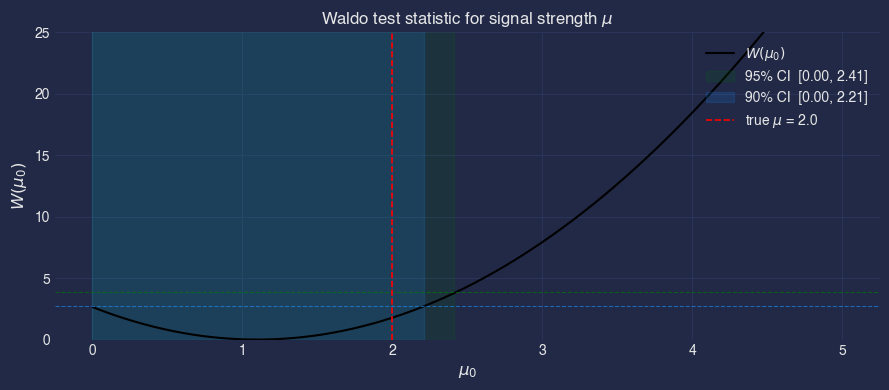

In [16]:
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(mu_grid, waldo, "k-", lw=1.5, label="$W(\\mu_0)$")

# 95% band
ax.fill_between(
    mu_grid, 0, waldo.max() * 1.05,
    where=(waldo < chi2_95), alpha=0.12, color="green",
    label=f"95% CI  [{ci95.min():.2f}, {ci95.max():.2f}]",
)
# 90% band
ax.fill_between(
    mu_grid, 0, waldo.max() * 1.05,
    where=(waldo < chi2_90), alpha=0.15, color="dodgerblue",
    label=f"90% CI  [{ci90.min():.2f}, {ci90.max():.2f}]",
)

ax.axhline(chi2_95, color="green", ls="--", lw=0.8, alpha=0.6)
ax.axhline(chi2_90, color="dodgerblue", ls="--", lw=0.8, alpha=0.6)
ax.axvline(mu_true, color="red", ls="--", lw=1.2, label=f"true $\\mu$ = {mu_true}")

ax.set_xlabel(r"$\mu_0$", fontsize=12)
ax.set_ylabel(r"$W(\mu_0)$", fontsize=12)
ax.set_title("Waldo test statistic for signal strength $\\mu$")
ax.set_ylim(0, min(waldo.max(), 25))
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Full 2D Waldo (joint)

The full Waldo for the joint parameter $\theta = (\mu, \nu)$:

$$
W(\theta_0) = (\hat{\theta} - \theta_0)^\top \hat{\Sigma}^{-1} (\hat{\theta} - \theta_0)
$$

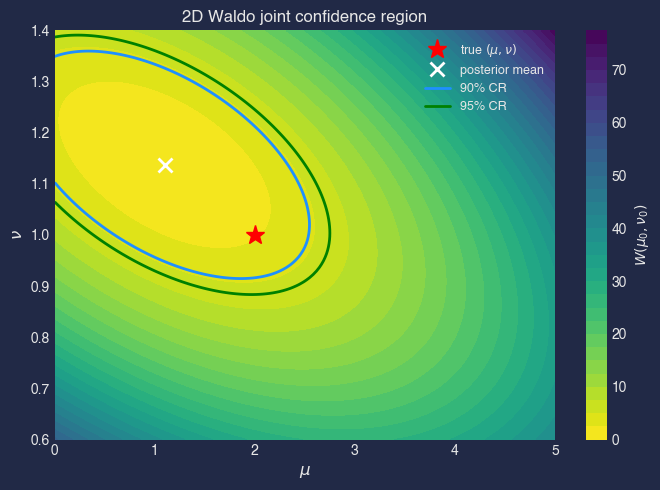

In [18]:
theta_hat = posterior_samples.numpy().mean(axis=0)         # (2,)
Sigma_hat = np.cov(posterior_samples.numpy(), rowvar=False) # (2, 2)
Sigma_inv = np.linalg.inv(Sigma_hat)

# evaluate on a (mu, nu) grid
mu_g = np.linspace(MU_LO, MU_HI, 150)
nu_g = np.linspace(NU_LO, NU_HI, 120)
MU_G, NU_G = np.meshgrid(mu_g, nu_g)
grid = np.stack([MU_G.ravel(), NU_G.ravel()], axis=-1)  # (M, 2)

diff = grid - theta_hat  # (M, 2)
W_2d = np.sum(diff @ Sigma_inv * diff, axis=-1).reshape(MU_G.shape)

# chi^2(2) critical values
chi2_2_90 = 4.605
chi2_2_95 = 5.991

fig, ax = plt.subplots(figsize=(7, 5))
cf = ax.contourf(MU_G, NU_G, W_2d, levels=30, cmap="viridis_r")
ax.contour(MU_G, NU_G, W_2d, levels=[chi2_2_90, chi2_2_95],
           colors=["dodgerblue", "green"], linewidths=2)
ax.plot(mu_true, nu_true, "r*", ms=14, label="true $(\\mu, \\nu)$", zorder=5)
ax.plot(theta_hat[0], theta_hat[1], "wx", ms=10, mew=2,
        label=f"posterior mean", zorder=5)

# dummy handles for contour legend
ax.plot([], [], color="dodgerblue", lw=2, label="90% CR")
ax.plot([], [], color="green", lw=2, label="95% CR")

fig.colorbar(cf, ax=ax, label="$W(\\mu_0, \\nu_0)$")
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel(r"$\nu$", fontsize=12)
ax.set_title("2D Waldo joint confidence region")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()